# PUC-Rio 
## Departamento de Engenharia Elétrica
## Trabalho 2 - Previsão de séries temporais
<p>Aluno: Giovani F. Machado

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Plotar gráfico do treinamento
def plot_train(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [3]:
# Converter de binário para decimal
def bin2dec(binary):
    return sum(int(val)*(2**idx) for idx, val in enumerate(reversed(binary)))

In [4]:
# Converter decimal para binário
def dec2bin(decimal):
    binary = [0]*4
    _binary = list(bin(decimal)[2:])
    _binary = _binary[::-1]
    for i, b in enumerate(_binary):
        binary[i] = int(b)
    binary = binary[::-1]
    return binary

In [5]:
def transform_data(data, lag = 1, test_split = 0.1, normalize = False, category = 'binary'):
    
    global _min
    global _max
    
    
    data_values = data.values
    
    if 0 < test_split < 1.0:
        l = data_values.shape[0]
        train_values = data_values[:-int(test_split*l),0].reshape(-1,1)
        test_values = data_values[-int(test_split*l):,0].reshape(-1,1)
        train_idx = data_values[:-int(test_split*l),1].reshape(-1,1)
        test_idx = data_values[-int(test_split*l):,1].reshape(-1,1)
        
    elif test_split > 1 and type(test_split) is int:

        train_values = data_values[:-test_split,0].reshape(-1,1)
        test_values = data_values[-test_split:,0].reshape(-1,1)
        train_idx = data_values[:-test_split,1].reshape(-1,1)
        test_idx = data_values[-test_split:,1].reshape(-1,1)
        
    else:
        print('Test split not understood. Test split should be float between 0 and 1 or integer for index')
    
    assert test_values.shape[0] >= (lag)
    
    _min = np.min(train_values)
    _max = np.max(train_values)
    
    if normalize:
        
        test_values = (test_values - _min)/(_max - _min)
        train_values = (train_values - _min)/(_max - _min)
        
    train_data = np.zeros((train_values.shape[0] - (lag + 1), lag + 2))
    test_data = np.zeros((test_values.shape[0], lag + 2))
    
    
    all_data = np.vstack((train_values,test_values))
    all_idx = np.vstack((train_idx,test_idx))

    new_data = np.zeros((train_values.shape[0] - (lag + 1) + test_values.shape[0],lag + 2))
    
    
    
    for i in range(lag + 2):
        new_data[:,i] = all_data[i:new_data.shape[0]+i,0]
        

    
    if category == 'binary':
        binary_rep = [np.binary_repr(z,width=4) for z in all_idx.astype('int').reshape(-1,)]
        t0 = np.array([int(v) for s in binary_rep for v in s[0]])
        t1 = np.array([int(v) for s in binary_rep for v in s[1]])
        t2 = np.array([int(v) for s in binary_rep for v in s[2]])
        t3 = np.array([int(v) for s in binary_rep for v in s[3]])
        t = np.vstack((t0,t1,t2,t3)).T
        t = t[-new_data.shape[0]:,:]
        temp_idx = [f'month_{i}' for i in range(4)]
        
#     elif category == '1toN':
#         pass
    elif category == '1toN':
        t = all_idx.astype(int).reshape(-1,) - 1
        t = np.squeeze(np.eye(12)[t])
        t = t[-new_data.shape[0]:,:]
        temp_idx = [f'month_{i}' for i in range(12)]
    
    else:
        t = (all_idx - np.min(train_idx))/(np.max(train_idx) - np.min(train_idx))
        t = t.reshape(-1,1)
        t = t[-new_data.shape[0]:,:]
        temp_idx = ['month']
    
    
    new_data = np.hstack((t,new_data))
    
    train_data = new_data[:-test_values.shape[0],:]
    test_data = new_data[-test_values.shape[0]:,:]
    
    
    data_columns = [f'y(t{i})' if i < 0 else 'y(t)' if i == 0 else f'y(t+{i})' for i in range(-lag,2)] 
    temp_idx.extend(data_columns)
    new_train_df = pd.DataFrame(train_data, columns=temp_idx)
    new_test_df = pd.DataFrame(test_data, columns=temp_idx)
    
    
    
    
    return new_train_df, new_test_df
        
    
    
    

## Leitura do dataset

In [6]:
raw_data = pd.read_csv('microclima3.csv')

In [7]:
raw_data

,value,time
0,39.277880,1.0
1,39.758673,2.0
2,37.317972,3.0
3,33.607143,4.0
4,27.605530,5.0
...,...,...
139,27.384332,8.0
140,30.956190,9.0
141,29.165438,10.0
142,37.649048,11.0


## 1. Compreensão do problema.

### 1.1. Visualize, em forma de gráfico, a dinâmica temporal da série escolhida. A série é adequada para a modelagem usando Redes Neurais? Caso não seja, que técnicas podem ser aplicadas para ajustar o comportamento da série?

Gráfico da Série

Text(0, 0.5, 'Temperatura')

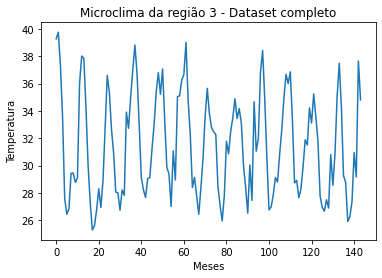

In [8]:
plt.plot(raw_data['value'])
plt.title('Microclima da região 3 - Dataset completo')
plt.xlabel('Meses')
plt.ylabel('Temperatura')

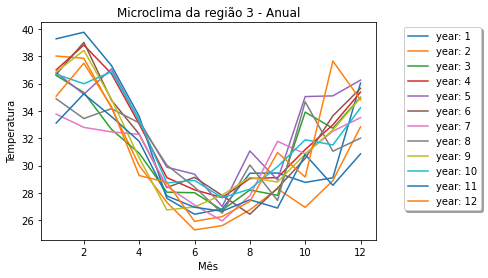

In [9]:
ax = plt.subplot(111)

for year in range(int(len(raw_data)/12)):
    ax.plot(raw_data['time'][year*12:year*12+12], raw_data['value'][year*12:year*12+12], label='year: '+str(year+1))

plt.title('Microclima da região 3 - Anual')
plt.xlabel('Mês')
plt.ylabel('Temperatura')
ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1.00), shadow=True, ncol=1)

## Resposta 1.1

<font color='red'>
É possível observar que a série temporal apresenta comportamento cíclico, apresentando temperaturas que se repetem periodicamente. Não é observada tendência que necessite ser retirada da série antes da modelagem. O segundo gráfico mostra a evolução de temperatura ao longo dos meses de cada ano.
</font>

### 1.2. No problema escolhido, usaremos uma variável exógena que representa o mês de previsão (i.e. no instante t+1). De que forma esta variável pode auxiliar na previsão da série temporal?

## Resposta 1.2
<font color='red'><p> Conforme observado no gráfico "Microclima da região 3 - Anual", a temperatura de um determinado mês costuma apresentar comportamento muito semelhante para os vários anos disponibilizados na série. Assim, a utilização do mês como variável exôgena pode auxiliar a previsão da temperatura nos meses futuros, trazendo esta informação de correlação. 
<\font>

## 2. Previsão one-step

### 2.1.a. Codificação numérica

In [10]:
train,test = transform_data(raw_data,lag=12,test_split = 12,normalize=True,category='numeric')

In [11]:
train

,month,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.090909,0.966754,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229
1,0.181818,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472
2,0.272727,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416
3,0.363636,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643
4,0.454545,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.636364,0.163287,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517
115,0.727273,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638
116,0.818182,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441
117,0.909091,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590


In [12]:
test

,month,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.000000,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615
1,0.090909,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498
2,0.181818,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367
3,0.272727,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147
4,0.363636,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339
5,0.454545,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136
6,0.545455,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530
7,0.636364,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327
8,0.727273,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317
9,0.818182,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317,0.267489


In [13]:
train_values = train.values
x_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test.values
x_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [14]:
x_train, y_train

(array([[0.09090909, 0.96675364, 1.        , ..., 0.26375394, 0.74280019,
         0.87966417],
        [0.18181818, 1.        , 0.83122802, ..., 0.74280019, 0.87966417,
         0.86822887],
        [0.27272727, 0.83122802, 0.57462797, ..., 0.87966417, 0.86822887,
         0.61747166],
        ...,
        [0.81818182, 0.32019268, 0.45591161, ..., 0.09458432, 0.15251651,
         0.11063836],
        [0.90909091, 0.45591161, 0.43000783, ..., 0.15251651, 0.11063836,
         0.38144103],
        [1.        , 0.43000783, 0.61756725, ..., 0.11063836, 0.38144103,
         0.22559029]]),
 array([0.86822887, 0.61747166, 0.32641608, 0.13964269, 0.        ,
        0.02151585, 0.10153109, 0.20820427, 0.11411811, 0.24943023,
        0.52165094, 0.78167657, 0.69502553, 0.50826726, 0.38802453,
        0.1909149 , 0.18811814, 0.10003339, 0.20209983, 0.1751774 ,
        0.59589845, 0.51413908, 0.67094261, 0.80952735, 0.93536688,
        0.78989797, 0.53593747, 0.26458883, 0.20286992, 0.16366957,
 

In [15]:
def create_model(hidden_neurons = [4], hidden_activation = ['relu'], output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    model = Sequential()
    model.add(Dense(hidden_neurons[0], input_dim=n_input, activation='tanh'))
    for i in range(1,len(hidden_neurons)):
        model.add(Dense(hidden_neurons[i], input_dim=hidden_neurons[i-1], activation='tanh'))
        

    model.add(Dense(n_output, activation=output_activation))
    # Compile model
    opt = Adam(lr=lr)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_absolute_error','mean_squared_error'])
    return model

In [16]:
model_numeric = create_model(hidden_neurons = [10], output_activation='linear', n_input = x_train.shape[1], n_output = 1, lr = 0.08)

In [17]:
history = model_numeric.fit(x=x_train,y=y_train,epochs=50)

Train on 119 samples
Epoch 1/50
119/119 [==============================] - 1s 5ms/sample - loss: 0.4985 - mean_absolute_error: 0.4985 - mean_squared_error: 0.3613
Epoch 2/50
119/119 [==============================] - 0s 109us/sample - loss: 0.2705 - mean_absolute_error: 0.2705 - mean_squared_error: 0.1014
Epoch 3/50
119/119 [==============================] - 0s 126us/sample - loss: 0.2240 - mean_absolute_error: 0.2240 - mean_squared_error: 0.0723
Epoch 4/50
119/119 [==============================] - 0s 118us/sample - loss: 0.1581 - mean_absolute_error: 0.1581 - mean_squared_error: 0.0416
Epoch 5/50
119/119 [==============================] - 0s 109us/sample - loss: 0.1252 - mean_absolute_error: 0.1252 - mean_squared_error: 0.0237
Epoch 6/50
119/119 [==============================] - 0s 134us/sample - loss: 0.1438 - mean_absolute_error: 0.1438 - mean_squared_error: 0.0314
Epoch 7/50
119/119 [==============================] - 0s 118us/sample - loss: 0.1229 - mean_absolute_error: 0.1229 - 

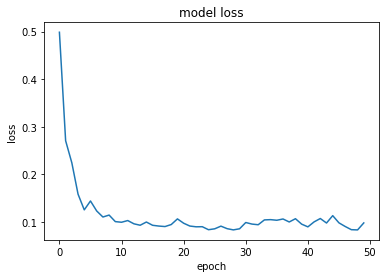

In [18]:
plot_train(history)

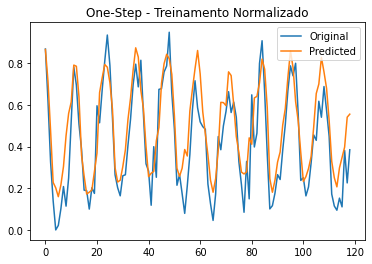

In [19]:
y_hat = model_numeric.predict(x_train)
plt.plot(y_train)
plt.plot(y_hat)
plt.title('One-Step - Treinamento Normalizado')
plt.legend(['Original','Predicted'])

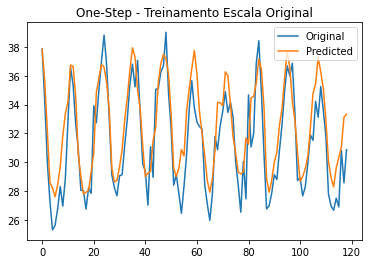

In [20]:
y_hat = model_numeric.predict(x_train)

# Voltando para a escala original
orig_y_train = y_train*(_max - _min) + _min
orig_y_hat_train = y_hat*(_max - _min) + _min

plt.plot(orig_y_train)
plt.plot(orig_y_hat_train)
plt.title('One-Step - Treinamento Escala Original')
plt.legend(['Original','Predicted'])

In [21]:
rmse_error_numTrain = mean_squared_error(orig_y_train, orig_y_hat_train, squared = False)
#squared: bool, default=True
#If True returns MSE value, if False returns RMSE value.

mae_error_numTrain = mean_absolute_error(orig_y_train, orig_y_hat_train)

mape_error_numTrain = mean_absolute_percentage_error(orig_y_train, orig_y_hat_train)

print(f'Erro RMSE = {round(rmse_error_numTrain,3)} \nErro MAE = {round(mae_error_numTrain,3)} \nErro MAPE = {round(mape_error_numTrain,3)}')

Erro RMSE = 1.953 
Erro MAE = 1.617 
Erro MAPE = 0.053


### Teste 'One step-ahead'

In [22]:
y_hat = model_numeric.predict(x_test)

In [23]:
#x_test

In [24]:
np.column_stack((y_hat, y_test))

array([[0.68170595, 0.67661474],
       [0.78123361, 0.84349753],
       [0.73337084, 0.62336684],
       [0.54706961, 0.27514706],
       [0.18229806, 0.24033889],
       [0.1877864 , 0.04313579],
       [0.17123985, 0.06753019],
       [0.1832799 , 0.14432697],
       [0.25976413, 0.39131733],
       [0.46604326, 0.26748862],
       [0.52056915, 0.85412154],
       [0.7725479 , 0.65835559]])

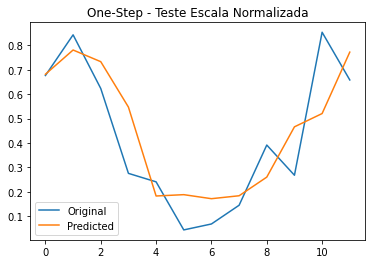

In [25]:
plt.plot(y_test)
plt.plot(y_hat)
plt.title('One-Step - Teste Escala Normalizada')
plt.legend(['Original','Predicted'])

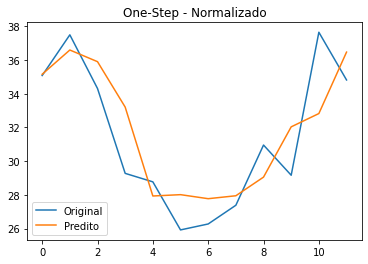

In [26]:
# denormalizing
orig_y_eval = y_test*(_max - _min) + _min
orig_y_hat = y_hat*(_max - _min) + _min

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.title('One-Step - Normalizado')
plt.legend(['Original','Predito'])

In [27]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error_num = mean_absolute_error(orig_y_eval, orig_y_hat)
rmse_error_num = mean_squared_error(orig_y_eval, orig_y_hat, squared = False)
#squared: bool, default=True
#If True returns MSE value, if False returns RMSE value.

mape_error_num = mean_absolute_percentage_error(orig_y_eval, orig_y_hat)

print(f'Erro RMSE = {round(rmse_error_num,3)} \nErro MAE = {round(mae_error_num,3)} \nErro MAPE = {round(mape_error_num,3)}')

Erro RMSE = 2.315 
Erro MAE = 1.895 
Erro MAPE = 0.061


## Resposta 2.1

In [28]:
print('Resultado utilizando codificação Numérica para o mês')
print('Treinamento')
print(f'Erro RMSE = {round(rmse_error_numTrain,3)} \nErro MAE = {round(mae_error_numTrain,3)} \nErro MAPE = {round(mape_error_numTrain,3)} \n')

print('Teste')
print(f'Erro RMSE = {round(rmse_error_num,3)} \nErro MAE = {round(mae_error_num,3)} \nErro MAPE = {round(mape_error_num,3)}')

Resultado utilizando codificação Numérica para o mês
Treinamento
Erro RMSE = 1.953 
Erro MAE = 1.617 
Erro MAPE = 0.053 

Teste
Erro RMSE = 2.315 
Erro MAE = 1.895 
Erro MAPE = 0.061


<font color='red'><p>
A métrica MAE nos traz uma visão do erro médio absoluto. Para o conjunto de teste o modelo, nas rodadas realizadas, apresentou MAE da ordem de 1 a 2 graus. Podemos interpretar que, em média, o modelo erra de 1 a 2 graus na base de teste. Para sabermos se este valor é muito ou pouco, podemos utilizar a MAPE, pois a MAPE normaliza os erros através da divisão pelo valor valor real.

<p>É possível observar através da métrica MAPE um erro abaixo de 1% tanto na etapa de treinamento quanto na etapa de teste. 

<p>Outra métrica bastante útil para entendimento e avaliação do modelo é a RMSE, através dela é possível termos uma noção de dispersão deste erro (mostra se houve alguns erros relativamente grandes) e se possíveis outliers estão reduzindo a performance do modelo.
</font>

### 2.1.b. Codificação binária

In [29]:
train,test = transform_data(raw_data,lag=12,test_split = 12,normalize=True,category='binary')

In [30]:
train

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,1.0,0.0,0.966754,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229
1,0.0,0.0,1.0,1.0,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472
2,0.0,1.0,0.0,0.0,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416
3,0.0,1.0,0.0,1.0,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643
4,0.0,1.0,1.0,0.0,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,1.0,0.0,0.0,0.0,0.163287,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517
115,1.0,0.0,0.0,1.0,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638
116,1.0,0.0,1.0,0.0,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441
117,1.0,0.0,1.0,1.0,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590


In [31]:
test

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,0.0,1.0,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615
1,0.0,0.0,1.0,0.0,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498
2,0.0,0.0,1.0,1.0,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367
3,0.0,1.0,0.0,0.0,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147
4,0.0,1.0,0.0,1.0,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339
5,0.0,1.0,1.0,0.0,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136
6,0.0,1.0,1.0,1.0,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530
7,1.0,0.0,0.0,0.0,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327
8,1.0,0.0,0.0,1.0,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317
9,1.0,0.0,1.0,0.0,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317,0.267489


In [32]:
train_values = train.values
x_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test.values
x_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [33]:
model_binary = create_model(hidden_neurons = [10], output_activation='linear', n_input = x_train.shape[1], n_output = 1, lr = 0.08)

In [34]:
history = model_binary.fit(x=x_train,y=y_train,epochs=50)

Train on 119 samples
Epoch 1/50
119/119 [==============================] - 0s 4ms/sample - loss: 1.2089 - mean_absolute_error: 1.2089 - mean_squared_error: 2.0368
Epoch 2/50
119/119 [==============================] - 0s 118us/sample - loss: 0.4434 - mean_absolute_error: 0.4434 - mean_squared_error: 0.2735
Epoch 3/50
119/119 [==============================] - 0s 118us/sample - loss: 0.2595 - mean_absolute_error: 0.2595 - mean_squared_error: 0.0985
Epoch 4/50
119/119 [==============================] - 0s 109us/sample - loss: 0.2006 - mean_absolute_error: 0.2006 - mean_squared_error: 0.0652
Epoch 5/50
119/119 [==============================] - 0s 109us/sample - loss: 0.1776 - mean_absolute_error: 0.1776 - mean_squared_error: 0.0456
Epoch 6/50
119/119 [==============================] - 0s 118us/sample - loss: 0.1491 - mean_absolute_error: 0.1491 - mean_squared_error: 0.0337
Epoch 7/50
119/119 [==============================] - 0s 109us/sample - loss: 0.1184 - mean_absolute_error: 0.1184 - 

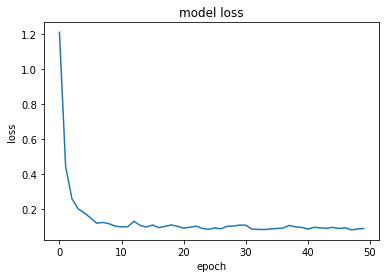

In [35]:
plot_train(history)

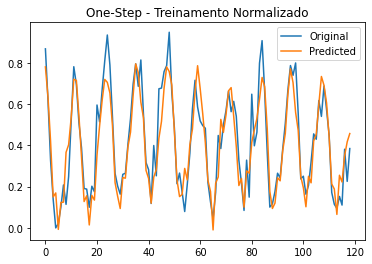

In [36]:
y_hat = model_binary.predict(x_train)
plt.plot(y_train)
plt.plot(y_hat)
plt.title('One-Step - Treinamento Normalizado')
plt.legend(['Original','Predicted'])

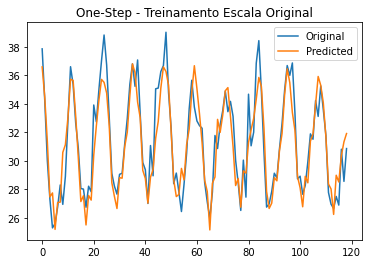

In [37]:
y_hat = model_binary.predict(x_train)

# Voltando para a escala original
orig_y_train = y_train*(_max - _min) + _min
orig_y_hat_train = y_hat*(_max - _min) + _min

plt.plot(orig_y_train)
plt.plot(orig_y_hat_train)
plt.title('One-Step - Treinamento Escala Original')
plt.legend(['Original','Predicted'])

In [38]:
mae_error_binTrain = mean_absolute_error(orig_y_train, orig_y_hat_train)
rmse_error_binTrain = mean_squared_error(orig_y_train, orig_y_hat_train, squared = False)
mape_error_binTrain = mean_squared_error(orig_y_train, orig_y_hat_train)

print(f'Erro RMSE = {round(rmse_error_binTrain,3)} \nErro MAE = {round(mae_error_binTrain,3)} \nErro MAPE = {round(mape_error_binTrain,3)}')

Erro RMSE = 1.434 
Erro MAE = 1.074 
Erro MAPE = 2.055


### Teste 'One step-ahead'

In [39]:
y_hat = model_binary.predict(x_test)

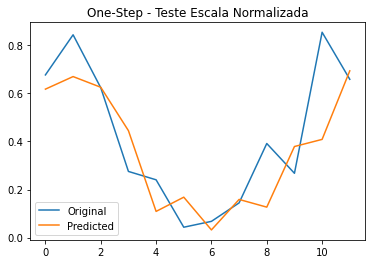

In [40]:
plt.plot(y_test)
plt.plot(y_hat)
plt.title('One-Step - Teste Escala Normalizada')
plt.legend(['Original','Predicted'])

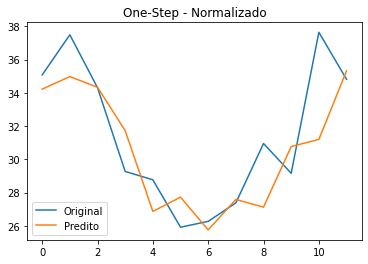

In [41]:
# denormalizing
orig_y_eval = y_test*(_max - _min) + _min
orig_y_hat = y_hat*(_max - _min) + _min

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.title('One-Step - Normalizado')
plt.legend(['Original','Predito'])

In [42]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error_bin = mean_absolute_error(orig_y_eval, orig_y_hat)
rmse_error_bin = mean_squared_error(orig_y_eval, orig_y_hat, squared = False)
mape_error_bin = mean_absolute_percentage_error(orig_y_eval, orig_y_hat)

print(f'Erro RMSE = {round(rmse_error_bin,3)} \nErro MAE = {round(mae_error_bin,3)} \nErro MAPE = {round(mape_error_bin,3)}')

Erro RMSE = 2.571 
Erro MAE = 1.889 
Erro MAPE = 0.059


## Resposta 2.2

In [43]:
print('Comparando os resultados de testes obtidos utilizando as codificações Numérica e Binária para o mês')
print('Numérica')
print(f'Erro RMSE = {round(rmse_error_num,3)} \nErro MAE = {round(mae_error_num,3)} \nErro MAPE = {round(mape_error_num,3)} \n')

print('Binária')
print(f'Erro RMSE = {round(rmse_error_bin,3)} \nErro MAE = {round(mae_error_bin,3)} \nErro MAPE = {round(mape_error_bin,3)}')

Comparando os resultados de testes obtidos utilizando as codificações Numérica e Binária para o mês
Numérica
Erro RMSE = 2.315 
Erro MAE = 1.895 
Erro MAPE = 0.061 

Binária
Erro RMSE = 2.571 
Erro MAE = 1.889 
Erro MAPE = 0.059


<font color='red'>
<p> A mudança da forma de codificar o mês altera a camada de entrada da rede neural. Quando a codificação numérica é utilizada, é necessário apenas 1 neurônio para receber esta informação. Quando a codificação binária é utilizada, são necessários 4 neurônios para receber esta informação na rede.
<p> O modelos obtidos com as duas codificações obtiveram resultados para as métricas MAE e MAPE bem semelhantes. A RMSE consistentemente apresentou resultados mais baixos para a codificação binária. 
<p> Os modelos consistentemente apresentaram MAE cerca de 1 grau no conjunto de treinamento e cerca de 2 graus no conjunto de testes. 
</font>

### 3. Previsão multi-step

### 3.1 Implemente o processo de previsão multi-step. Faça a previsão multi-step para o horizonte de previsão igual a 12 e analise os resultados.

In [44]:
train,test = transform_data(raw_data, lag=12, test_split=12, normalize=True, category='binary')

In [45]:
train

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,1.0,0.0,0.966754,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229
1,0.0,0.0,1.0,1.0,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472
2,0.0,1.0,0.0,0.0,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416
3,0.0,1.0,0.0,1.0,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643
4,0.0,1.0,1.0,0.0,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,1.0,0.0,0.0,0.0,0.163287,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517
115,1.0,0.0,0.0,1.0,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638
116,1.0,0.0,1.0,0.0,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441
117,1.0,0.0,1.0,1.0,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590


In [46]:
test

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,0.0,1.0,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615
1,0.0,0.0,1.0,0.0,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498
2,0.0,0.0,1.0,1.0,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367
3,0.0,1.0,0.0,0.0,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147
4,0.0,1.0,0.0,1.0,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339
5,0.0,1.0,1.0,0.0,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136
6,0.0,1.0,1.0,1.0,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530
7,1.0,0.0,0.0,0.0,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327
8,1.0,0.0,0.0,1.0,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317
9,1.0,0.0,1.0,0.0,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317,0.267489


In [47]:
train_values = train.values
x_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test.values
x_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [48]:
model = create_model(hidden_neurons = [10], output_activation='linear', n_input = x_train.shape[1], n_output = 1, lr = 0.08)

In [49]:
# Armazenar os resultados
y_result = []

# Primeiro vetor de entrada para previsão multi-step
x_test0 = np.copy(x_test[0])

# Tamanho do vetor de entrada
s = x_test0.shape[0]

for i in range(12):
    _y_hat = model.predict(x_test0.reshape(1, -1))
    
    # Atualizar variavel mês (exôgena)
    x_test0[0:4] = dec2bin(bin2dec(x_test0[0:4]) + 1)
    #print(x_test0[0:4])
    
    # Delizar os valores
    # ex.: x[0] <- x[1], x[1] <- x[2], x[2] <- x[3]
    x_test0[4:s-1] = x_test0[5:]
    #print(x_test0[4:s-1])
    
    # Atualizar ultimo valor
    x_test0[-1] = _y_hat
    
    orig_y_hat_multistep = _y_hat[0][0]*(_max - _min) + _min
    
    # Armazenar o resultado
    y_result.append(orig_y_hat_multistep)

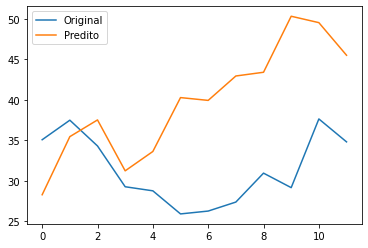

In [50]:
# # denormalizing
#orig_y_eval = y_test*(_max - _min) + _min

plt.plot(orig_y_eval)
plt.plot(y_result)
plt.legend(['Original','Predito'])

In [51]:
mae_error = mean_absolute_error(orig_y_eval, y_result)
rmse_error = mean_squared_error(orig_y_eval, y_result, squared = False)
mape_error = mean_absolute_percentage_error(orig_y_eval, y_result)

print(f'Erro RMSE = {round(rmse_error,3)} \nErro MAE = {round(mae_error,3)} \nErro MAPE = {round(mape_error,3)}')

Erro RMSE = 11.484 
Erro MAE = 9.89 
Erro MAPE = 0.331


## Resposta 3.1

<font color='red'>
A partir da análise do gráfico e das métricas, é possível observar que para a previsão multi-step o modelo teve dificuldade em reproduzir a série. O efeito de propagação dos erros trouxe resultados de MAPE variando entre 0,2 e 0,3 de forma consistente. A RMSE indicou dispersão na faixa de 6 a 10 graus e a MAE um desvio médio de 6 a 9 graus.
</font>

### 3.2. Modifique o tamanho da janela de entrada e avalie os resultados.

In [52]:
train,test = transform_data(raw_data, lag=4, test_split=12, normalize=True, category='binary')

In [53]:
train

,month_0,month_1,month_2,month_3,y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,1.0,1.0,0.0,0.966754,1.000000,0.831228,0.574628,0.159623,0.079324
1,0.0,1.0,1.0,1.0,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737
2,1.0,0.0,0.0,0.0,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608
3,1.0,0.0,0.0,1.0,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055
4,1.0,0.0,1.0,0.0,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466
...,...,...,...,...,...,...,...,...,...,...
122,1.0,0.0,0.0,0.0,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517
123,1.0,0.0,0.0,1.0,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638
124,1.0,0.0,1.0,0.0,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441
125,1.0,0.0,1.0,1.0,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590


In [54]:
test

,month_0,month_1,month_2,month_3,y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,0.0,1.0,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615
1,0.0,0.0,1.0,0.0,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498
2,0.0,0.0,1.0,1.0,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367
3,0.0,1.0,0.0,0.0,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147
4,0.0,1.0,0.0,1.0,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339
5,0.0,1.0,1.0,0.0,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136
6,0.0,1.0,1.0,1.0,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530
7,1.0,0.0,0.0,0.0,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327
8,1.0,0.0,0.0,1.0,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317
9,1.0,0.0,1.0,0.0,0.240339,0.043136,0.067530,0.144327,0.391317,0.267489


In [55]:
train_values = train.values
x_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test.values
x_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [56]:
model = create_model(hidden_neurons = [10], output_activation='linear', n_input = x_train.shape[1], n_output = 1, lr = 0.08)

In [57]:
history = model.fit(x=x_train,y=y_train,epochs=50)

Train on 127 samples
Epoch 1/50
127/127 [==============================] - 0s 2ms/sample - loss: 0.6035 - mean_absolute_error: 0.6035 - mean_squared_error: 0.4860
Epoch 2/50
127/127 [==============================] - 0s 94us/sample - loss: 0.3698 - mean_absolute_error: 0.3698 - mean_squared_error: 0.2180
Epoch 3/50
127/127 [==============================] - 0s 102us/sample - loss: 0.2787 - mean_absolute_error: 0.2787 - mean_squared_error: 0.1169
Epoch 4/50
127/127 [==============================] - 0s 94us/sample - loss: 0.2315 - mean_absolute_error: 0.2315 - mean_squared_error: 0.0843
Epoch 5/50
127/127 [==============================] - 0s 87us/sample - loss: 0.1963 - mean_absolute_error: 0.1963 - mean_squared_error: 0.0577
Epoch 6/50
127/127 [==============================] - 0s 94us/sample - loss: 0.1534 - mean_absolute_error: 0.1534 - mean_squared_error: 0.0368
Epoch 7/50
127/127 [==============================] - 0s 87us/sample - loss: 0.1278 - mean_absolute_error: 0.1278 - mean_

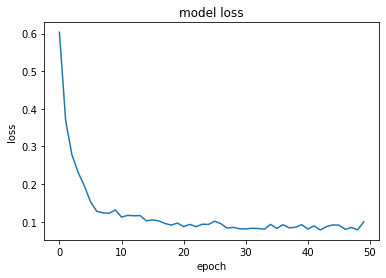

In [58]:
plot_train(history)

In [59]:
# Armazenar os resultados
y_result = []

# Primeiro vetor de entrada para previsão multi-step
x_test0 = np.copy(x_test[0])

# Tamanho do vetor de entrada
s = x_test0.shape[0]

for i in range(12):
    _y_hat = model.predict(x_test0.reshape(1, -1))
    
    # Atualizar variavel mês (exôgena)
    x_test0[0:4] = dec2bin(bin2dec(x_test0[0:4]) + 1)
    #print(x_test0[0:4])
    
    # Delizar os valores
    # ex.: x[0] <- x[1], x[1] <- x[2], x[2] <- x[3]
    x_test0[4:s-1] = x_test0[5:]
    #print(x_test0[4:s-1])
    
    # Atualizar ultimo valor
    x_test0[-1] = _y_hat
    
    orig_y_hat_multistep = _y_hat[0][0]*(_max - _min) + _min
    
    # Armazenar o resultado
    y_result.append(orig_y_hat_multistep)

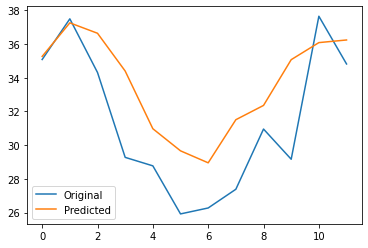

In [60]:
# # denormalizing
orig_y_eval = y_test*(_max - _min) + _min

plt.plot(orig_y_eval)
plt.plot(y_result)
plt.legend(['Original','Predicted'])

In [61]:
#orig_y_eval

In [62]:
mae_error = mean_absolute_error(orig_y_eval, y_result)
rmse_error = mean_squared_error(orig_y_eval, y_result, squared = False)
mape_error = mean_absolute_percentage_error(orig_y_eval, y_result)

print(f'Erro RMSE = {round(rmse_error,3)} \nErro MAE = {round(mae_error,3)} \nErro MAPE = {round(mape_error,3)}')

Erro RMSE = 3.111 
Erro MAE = 2.576 
Erro MAPE = 0.088


## Resposta 3.2

<font color='red'>
Com a redução da janela (considerando temperatura do mês atual e os três anteriores) é possível notar que houve uma melhora do resultado quando comparado com o resultado do modelo com a janela de entrada que considerava os 12 meses anteriores e o atual. Todas as métricas tiveram os erros reduzidos para quase a metade do observado anteriormente. Pode-se atribuir isto ao fato de existir grande correlação entre as temperaturas dos mesmos meses a cada ano, sendo possível, assim, obter melhores resultados mesmo descartando várias medições da série.
</font>

## 3.3. Modifique a topologia da rede para obter um melhor desempenho. Altere seus parâmetros (e.g. número de processadores na camada escondida, tipo de função na camada de saída) e avalie o desempenho em termos das métricas RMSE e MAE

In [63]:
model = create_model(hidden_neurons = [30], hidden_activation='lrelu', output_activation='linear', n_input = x_train.shape[1], n_output = 1, lr = 0.08)

In [64]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 30)                300       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 31        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [65]:
history = model.fit(x=x_train,y=y_train,epochs=50)

Train on 127 samples
Epoch 1/50
127/127 [==============================] - 0s 3ms/sample - loss: 1.1083 - mean_absolute_error: 1.1083 - mean_squared_error: 1.8656
Epoch 2/50
127/127 [==============================] - 0s 134us/sample - loss: 0.7245 - mean_absolute_error: 0.7245 - mean_squared_error: 0.6904
Epoch 3/50
127/127 [==============================] - 0s 110us/sample - loss: 0.5599 - mean_absolute_error: 0.5599 - mean_squared_error: 0.4221
Epoch 4/50
127/127 [==============================] - 0s 95us/sample - loss: 0.4530 - mean_absolute_error: 0.4530 - mean_squared_error: 0.2900
Epoch 5/50
127/127 [==============================] - 0s 181us/sample - loss: 0.2989 - mean_absolute_error: 0.2989 - mean_squared_error: 0.1203
Epoch 6/50
127/127 [==============================] - 0s 87us/sample - loss: 0.2444 - mean_absolute_error: 0.2444 - mean_squared_error: 0.0911
Epoch 7/50
127/127 [==============================] - 0s 94us/sample - loss: 0.2281 - mean_absolute_error: 0.2281 - mea

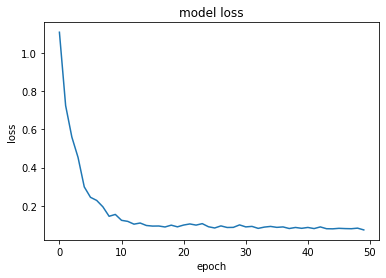

In [66]:
plot_train(history)

In [67]:
# armazenar resultados
y_result = []

# primeiro vetor de entrada para previsão multi-step
x_test0 = np.copy(x_test[0])

# tamanho do vetor de entrada
s = x_test0.shape[0]

for i in range(12):
    _y_hat = model.predict(x_test0.reshape(1, -1))
    
    # atualização da variavel exogena (mês)
    x_test0[0:4] = dec2bin(bin2dec(x_test0[0:4]) + 1)
    
    # shift nos valores
    x_test0[4:s-1] = x_test0[5:]
    
    # atualizando ultimo valor
    x_test0[-1] = _y_hat
    
    orig_y_hat_multistep = _y_hat[0][0]*(_max - _min) + _min
    
    # armazena o resultado
    y_result.append(orig_y_hat_multistep)

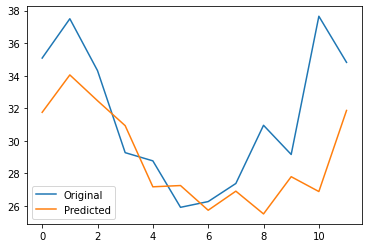

In [68]:
 # denormalizing
orig_y_eval = y_test*(_max - _min) + _min

plt.plot(orig_y_eval)
plt.plot(y_result)
plt.legend(['Original','Predicted'])

In [69]:
mae_error = mean_absolute_error(orig_y_eval, y_result)
rmse_error = mean_squared_error(orig_y_eval, y_result, squared = False)
mape_error = mean_absolute_percentage_error(orig_y_eval, y_result)

print(f'Erro RMSE = {round(rmse_error,3)} \nErro MAE = {round(mae_error,3)} \nErro MAPE = {round(mape_error,3)}')

Erro RMSE = 3.978 
Erro MAE = 2.894 
Erro MAPE = 0.086


## Resposta 3.3

<font color='red'>
Nos testes que foram realizados, não se observou tendência de piora ou melhora com os parâmetros testados. Em algumas rodadas, o modelo mais simples apresentou resultados melhores em outras o modelo maus complexo mostrou melhores resulatdos. Em todas as rodadas se observou MAPE variando entre 6 e 10%, MAE entre 1,5 e 2,5 graus e RMSE entre 2 e 3 graus.
</font>

## 3.4 Implemente a codificação ‘1 of N’ (apresentada em sala de aula) e use-a para modificar a representação da variável ‘mês’. Qual a mudança existente na arquitetura da Rede Neural? Avalie o desempenho em termos das métricas RMSE e MAE.

In [70]:
train,test = transform_data(raw_data, lag=3, test_split=12, normalize=True, category='1toN')

In [71]:
train

,month_0,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.966754,1.000000,0.831228,0.574628,0.159623
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.831228,0.574628,0.159623,0.079324
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.831228,0.574628,0.159623,0.079324,0.105737
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.574628,0.159623,0.079324,0.105737,0.286608
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.159623,0.079324,0.105737,0.286608,0.288055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.448349,0.171795,0.114689,0.094584,0.152517
124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.171795,0.114689,0.094584,0.152517,0.110638
125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.114689,0.094584,0.152517,0.110638,0.381441
126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.094584,0.152517,0.110638,0.381441,0.225590


In [72]:
test

,month_0,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.110638,0.381441,0.225590,0.384723,0.676615
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.381441,0.225590,0.384723,0.676615,0.843498
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.225590,0.384723,0.676615,0.843498,0.623367
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.384723,0.676615,0.843498,0.623367,0.275147
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.676615,0.843498,0.623367,0.275147,0.240339
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.843498,0.623367,0.275147,0.240339,0.043136
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.623367,0.275147,0.240339,0.043136,0.067530
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.275147,0.240339,0.043136,0.067530,0.144327
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.240339,0.043136,0.067530,0.144327,0.391317
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.043136,0.067530,0.144327,0.391317,0.267489


In [73]:
train_values = train.values
x_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test.values
x_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [74]:
model = create_model(hidden_neurons = [10], hidden_activation='lrelu', output_activation='linear', n_input = x_train.shape[1], n_output = 1, lr = 0.08)

In [75]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 10)                170       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [76]:
history = model.fit(x=x_train,y=y_train,epochs=50)

Train on 128 samples
Epoch 1/50
128/128 [==============================] - 0s 3ms/sample - loss: 0.4654 - mean_absolute_error: 0.4654 - mean_squared_error: 0.3116
Epoch 2/50
128/128 [==============================] - 0s 70us/sample - loss: 0.3726 - mean_absolute_error: 0.3726 - mean_squared_error: 0.1854
Epoch 3/50
128/128 [==============================] - 0s 70us/sample - loss: 0.2676 - mean_absolute_error: 0.2676 - mean_squared_error: 0.1047
Epoch 4/50
128/128 [==============================] - 0s 70us/sample - loss: 0.1899 - mean_absolute_error: 0.1899 - mean_squared_error: 0.0539
Epoch 5/50
128/128 [==============================] - 0s 70us/sample - loss: 0.1568 - mean_absolute_error: 0.1568 - mean_squared_error: 0.0373
Epoch 6/50
128/128 [==============================] - 0s 70us/sample - loss: 0.1319 - mean_absolute_error: 0.1319 - mean_squared_error: 0.0282
Epoch 7/50
128/128 [==============================] - 0s 86us/sample - loss: 0.1265 - mean_absolute_error: 0.1265 - mean_s

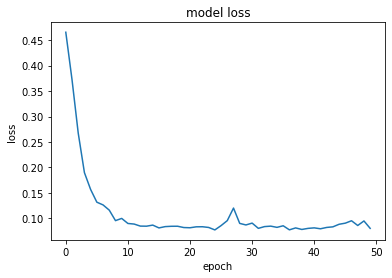

In [77]:
plot_train(history)

In [78]:
# armazenar resultados
y_result = []

# primeiro vetor de entrada para previsão multi-step
x_test0 = np.copy(x_test[0])

# tamanho do vetor de entrada
s = x_test0.shape[0]

for i in range(12):
    #print(x_test0)
    _y_hat = model.predict(x_test0.reshape(1, -1))
    #print(_y_hat)
    
    # atualização da variavel exogena (mês)
    x_test0[0:12] = np.roll(x_test0[0:12],1)
    #print(x_test0[0:12])
    
    
    # shift nos valores
    x_test0[12:s-1] = x_test0[13:]
    #print(x_test0[12:s-1])
    
    # atualizando ultimo valor
    x_test0[-1] = _y_hat
    
    orig_y_hat_multistep = _y_hat[0][0]*(_max - _min) + _min
    
    # armazena o resultado
    y_result.append(orig_y_hat_multistep)

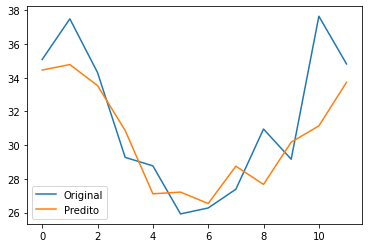

In [79]:
plt.plot(orig_y_eval)
plt.plot(y_result)
plt.legend(['Original','Predito'])

In [80]:
mae_error = mean_absolute_error(orig_y_eval, y_result)
rmse_error = mean_squared_error(orig_y_eval, y_result, squared = False)
mape_error = mean_absolute_percentage_error(orig_y_eval, y_result)

print(f'Erro RMSE = {round(rmse_error,3)} \nErro MAE = {round(mae_error,3)} \nErro MAPE = {round(mape_error,3)}')

Erro RMSE = 2.459 
Erro MAE = 1.849 
Erro MAPE = 0.057


## Resposta 3.4

<font color='red'>
Com esta codificação a mudança de arquitetura ocorre obrigatoriamente na camada de entrada. Na codificação numérica e binária havia, respectivamente, 1 e 4 neurônios na camada de entrada da rede. Com a codificação para utilização pA  of N, a camada de entrada passa a contar com 12 neurônios para receber a variável exógena. Com esta codificação, e o uso da distência de hamming, foram observados consistentemente os melhores resultados entre os modelos testados. A MAPE variou entre 5 e 6%, com a MAE variando entre 1,5 e 2 graus e a RMSE em torno de 2,35. 
</font>